## <center>CITS5508 Lab sheet 3: Decision Tree Classification</center>

**Name: Samuel Heath**<br>
**Student number: 21725083**<br>

Looks at two different datasets and performs Decision Tree Classification on each set.

## Project 1 - UCI ecoli Dataset
### Summary:
- Load and clean data.
- Remove Classes that dont have enough instances.
- Remove unneeded features and scale the dataset.
- Compare DT Classifier and SVM Classifier results based on trained data sets.

##### Load Data from `./ecoli.data` and initially visualise the data to see if any classes cant be used.

In [1]:
import pandas as pd

# Set the random seed to ensusre consistent results
random_seed = 12

# Lables we want to add to the data
labels = ["sequence", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "label"]
ecoli_data = pd.read_csv('./ecoli.data', delim_whitespace=True, names=labels)

ecoli_data = ecoli_data.drop("sequence", axis=1)

ecoli_data.head(10)

,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp
7,0.21,0.34,0.48,0.5,0.51,0.28,0.39,cp
8,0.20,0.44,0.48,0.5,0.46,0.51,0.57,cp
9,0.42,0.40,0.48,0.5,0.56,0.18,0.30,cp


## Check the class distribution and remove those with < 10

In [2]:
import matplotlib.pyplot as plt

ecoli_data_copy = ecoli_data.copy()

plt.figure(figsize=(8, 8))
plt.bar(x=ecoli_data_copy.sort_values('label')['label'].unique(), height=ecoli_data_copy.groupby('label').size())
plt.show()

<Figure size 800x800 with 1 Axes>

From this we see that imL, imS, and omL cannot be used for classificiation due to their low number of training instances, so lets remove these classes from the dataset.

In [3]:
ecoli_data = ecoli_data.drop(ecoli_data[ecoli_data.label.isin(["imL", "imS", "omL"])].index)
ecoli_data.reset_index()

ecoli_data.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## Split the dataset into training and testing datasets
Before we learn against this dataset we need to separate out our set into a training and testing set allowing us to validated the accuracy of our model. Peform the split using StratifiedShuffleSplit, resulting in a test size of 20% and training size of 80%. StratifiedShuffleSplit shuffles the dataset once before attempting to evenly distribute (based on the distribution of values) the samples of each label (`ecoli_data.label`) into both the training and testing datasets.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

sss = StratifiedShuffleSplit(random_state=random_seed, test_size=0.2, train_size=0.8)

le = LabelEncoder()
ecoli_data.label = le.fit_transform(ecoli_data.label)

for train_index, test_index in sss.split(ecoli_data, ecoli_data.label):
    X_train, X_test = ecoli_data.iloc[train_index], ecoli_data.iloc[test_index]    

# Get the labels of the dataset
y_train, y_test = X_train.label, X_test.label

# Drop Labels from X
X_train = X_train.drop("label", axis=1)
X_test = X_test.drop("label", axis=1)

Create scaled versions of the dataset so the SVM can later be run on both the original and the scaled datasets

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit the data to a Model
Make two different models of the data using Support Vector Machines and Decision Trees

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create a Decision Tree
dt = DecisionTreeClassifier(random_state=random_seed).fit(X_train_scaled, y_train)
dt_test_predict = dt.predict(X_test_scaled)

# Create a Support Vector Classifier
svm = SVC(gamma="auto", kernel="poly", degree=3, random_state=random_seed).fit(X_train_scaled, y_train)
svm_test_predict = svm.predict(X_test_scaled)

### Accuracy of Fitted Models
Compare the accuracy of the fitted models using their cross validated prediction accuracy, f1 score, their confusion matrices.

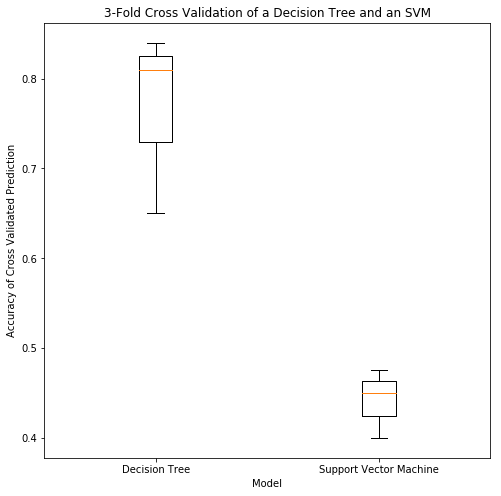

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

dt_y_predict = cross_val_score(dt, X_test_scaled, y_test, cv=3)
svm_y_predict = cross_val_score(svm, X_test_scaled, y_test, cv=3)

plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, svm_y_predict], labels=["Decision Tree", "Support Vector Machine"])
plt.title("3-Fold Cross Validation of a Decision Tree and an SVM")
plt.ylabel("Accuracy of Cross Validated Prediction")
plt.xlabel("Model")
plt.show()

## Comments on the Different Models Accuracy

In [8]:
f1_score(y_test, dt_test_predict, average="micro"), f1_score(y_test, svm_test_predict, average="micro")

(0.8333333333333334, 0.48484848484848486)

In [9]:
confusion_matrix(y_test, dt_test_predict)
confusion_matrix(y_test, svm_test_predict)

array([[29,  0,  0,  0,  0],
       [13,  3,  0,  0,  0],
       [ 5,  2,  0,  0,  0],
       [ 4,  0,  0,  0,  0],
       [10,  0,  0,  0,  0]], dtype=int64)

Comment on confusion matrices differences

### DT and Support Vector Machine Unnormalized
Fit the unscaled data to the DT and Support Vector Machine and compare the results between each model with and without scaling of the features.

In [10]:
# Create unscaled DT Classifier
dt_raw = DecisionTreeClassifier(random_state=random_seed).fit(X_train, y_train)
dt_raw_y_test_predict = dt_raw.predict(X_test)

# Cross Validate the prediction of an unscaled DT classifier
dt_raw_y_predict = cross_val_score(dt_raw, X_test, y_test, cv=3)

# Create Unscaled SVM
svm_raw = SVC(gamma="auto", random_state=random_seed, kernel="poly").fit(X_train, y_train)
svm_raw_y_test_predict = svm_raw.predict(X_test)

# Cross validate the prediction of the unscaled SVM
svm_raw_y_predict = cross_val_score(svm_raw, X_test, y_test, cv=3)

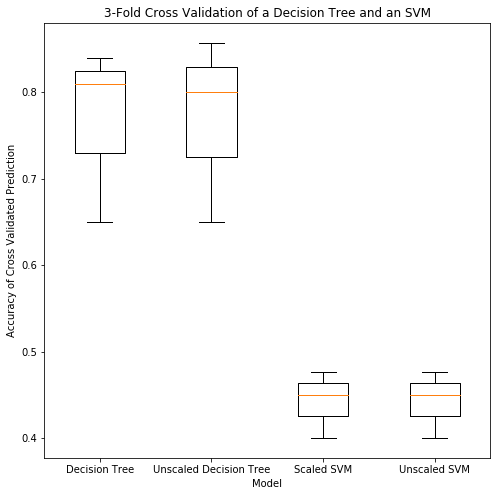

In [11]:
# Visualise the results in a bar graph
plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, dt_raw_y_predict, svm_y_predict, svm_raw_y_predict], labels=["Decision Tree", "Unscaled Decision Tree", "Scaled SVM", "Unscaled SVM"])
plt.title("3-Fold Cross Validation of a Decision Tree and an SVM")
plt.ylabel("Accuracy of Cross Validated Prediction")
plt.xlabel("Model")
plt.show()

In [12]:
f1_score(y_test, svm_raw_y_test_predict, average="micro")

0.5606060606060606

As expected Support Vector Machines are highly variable based on the feature scaling present. This is shown through the significantly lower f1 score of `45%` of the SVM trained on the unscaled data compared with the `79%` score of the SVM trained on the scaled data.

## Project 2 - BOM Dataset
### Summary:
- Load datasets and create a DT and SVM regressor capable of predicting the maximum temperature based on the solar exposure and a month and date.
- Report the MSE of the two regressors

### Load and Clean the Data
##### Load Data from `./SolarExposure_2018_Data.csv` and `./Temperature_2018_Data.csv`

In [13]:
solar_exposure = pd.read_csv("./SolarExposure_2018_Data.csv")
per_temp = pd.read_csv("./Temperature_2018_Data.csv")

print(solar_exposure.describe())
per_temp.describe()

       Bureau of Meteorology station number    Year       Month         Day  \
count                                 365.0   365.0  365.000000  365.000000   
mean                                 9225.0  2018.0    6.526027   15.720548   
std                                     0.0     0.0    3.452584    8.808321   
min                                  9225.0  2018.0    1.000000    1.000000   
25%                                  9225.0  2018.0    4.000000    8.000000   
50%                                  9225.0  2018.0    7.000000   16.000000   
75%                                  9225.0  2018.0   10.000000   23.000000   
max                                  9225.0  2018.0   12.000000   31.000000   

       Daily global solar exposure (MJ/m*m)  
count                            365.000000  
mean                              18.883014  
std                                7.771997  
min                                2.900000  
25%                               12.200000  
50%         

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature
count,365.0,365.0,365.000000,365.000000,365.000000,365.0
mean,9225.0,2018.0,6.526027,15.720548,24.654795,1.0
std,0.0,0.0,3.452584,8.808321,5.566018,0.0
min,9225.0,2018.0,1.000000,1.000000,14.100000,1.0
25%,9225.0,2018.0,4.000000,8.000000,20.000000,1.0
50%,9225.0,2018.0,7.000000,16.000000,24.200000,1.0
75%,9225.0,2018.0,10.000000,23.000000,28.700000,1.0
max,9225.0,2018.0,12.000000,31.000000,41.200000,1.0


We dont need the `Product code` and the `Bureau of meterology station number` as the only inputs into these regressors will be the date, solar exposure and a prediction of the maximum tempterature. Based on the .txt file most of the data quality has been checked and it is unlikely that the quality of a N instance will be particularly bad so lets remove that row as well. From the description of the `per_temp` dataset the days of accumulation is all 1 and we know the data is only from 2018 so we can remove the `Year` and `days of accumulation` feature.

In [14]:
drop_cols = ["Year","Product code", "Bureau of Meteorology station number"]
solar_exposure = solar_exposure.drop(drop_cols, axis=1)
per_temp = per_temp.drop(drop_cols + ["Quality", "Days of accumulation of maximum temperature"], axis=1)

We need to be do a regression using the date and global solar exposure to predict maximum tempterature so lets merge datasets on the date columns.

In [15]:
merge_cols = ["Month", "Day"]
combined_data = pd.merge(solar_exposure, per_temp, how="left", left_on=merge_cols, right_on=merge_cols)

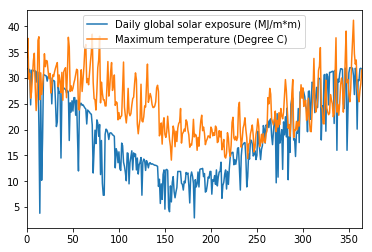

In [16]:
# Get an overview of the shape of the data coming in.
combined_data[["Daily global solar exposure (MJ/m*m)", "Maximum temperature (Degree C)"]].plot()
plt.show()

From the above plot we can see that the daily solar exposure appears to follow a rougly parabolic shape so a second degree polynomial may be useful.

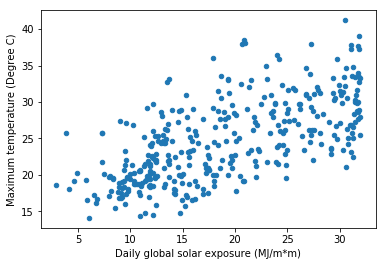

In [17]:
# Compare solar exposure with respect to maximum temperature
combined_data.plot.scatter(x='Daily global solar exposure (MJ/m*m)', y='Maximum temperature (Degree C)')
plt.show()

From the above plot there appears to be a relatively linear trend in the maximum temperature based on the global solar exposure which would be expected. However there appears to be quite a lot of variability which is likely to do with the time of year.

### Create Training and Test Datasets
Split the data in a 20/80 split for training and testing using a ShuffleSplit

In [18]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(train_size=0.8, test_size=0.2, random_state=random_seed)

target = "Maximum temperature (Degree C)"

for train_index, test_index in ss.split(combined_data.iloc[:, :len(combined_data.columns)-2], combined_data[target]):
    X_train2, X_test2 = combined_data.iloc[train_index], combined_data.iloc[test_index]
    y_train2, y_test2 = combined_data.iloc[train_index][target], combined_data.iloc[test_index][target]

X_train2.drop("Maximum temperature (Degree C)", axis=1)
X_test2.drop("Maximum temperature (Degree C)", axis=1)

,Month,Day,Daily global solar exposure (MJ/m*m)
331,11,28,31.2
216,8,5,12.2
299,10,27,27.6
363,12,30,31.9
10,1,11,29.2
356,12,23,26.8
204,7,24,11.1
180,6,30,11.0
107,4,18,11.7
170,6,20,8.3


Create feature scaled datasets to allow us to compare the results of the these regressors on scaled and unscaled feature sets

In [19]:
scaler = MinMaxScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

c:\users\gosia\documents\cits5508\venv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Fit the scaled and unscaled feature sets to each of the DecisionTreeRegressor and SVM Regressors
We can later compare the accuracy of each of these models and then compare how these models respond to scaled and unscaled feature sets.

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# DTR on a scaled feature set
dtr = DecisionTreeRegressor(random_state=random_seed)
dtr.fit(X_train2_scaled, y_train2)

dtr_test_predict = dtr.predict(X_test2_scaled)


dtr_raw = DecisionTreeRegressor(random_state=random_seed)
dtr_raw.fit(X_train2, y_train2)

dtr_raw_test_predict = dtr_raw.predict(X_test2)


# SVR on a scaled feature set
svr = SVR(gamma="auto", kernel="poly")
svr.fit(X_train2_scaled, y_train2)

svr_test_predict = svr.predict(X_test2_scaled)


# SVR on an unscaled feature set
svr_raw = SVR(gamma="auto", kernel="poly")
svr_raw.fit(X_train2, y_train2)

svr_raw_test_predict = svr_raw.predict(X_test2)

Compare the Scaled and Unscaled Feature Set Error Rates of each Model to determine the effect of scaling on each models accuracy, and which model is the best predictor.

In [28]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test2, dtr_test_predict), mean_squared_error(y_test2, dtr_raw_test_predict))
print(mean_squared_error(y_test2, svr_test_predict), mean_squared_error(y_test2, svr_raw_test_predict))

0.005479452054794574 0.005479452054794574
19.976419649447468 180.18216069438566
